<a href="https://colab.research.google.com/github/GKS07/NLP-Projects/blob/main/Language_Translator_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>English to French Translation</h1>
 I'll be using seq to seq model with attention to create a simple language translator.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import files
files.upload()

# copying the kaggle file

!mkdir ~/.kaggle # nmaking the folder

! cp kaggle.json ~/.kaggle/  #copy the file

#changing the permission.
! chmod 600 ~/.kaggle/kaggle.json


# downloading the data from kaggle

!kaggle datasets download -d devicharith/language-translation-englishfrench
# making the folder
!mkdir English_2_French

Saving kaggle.json to kaggle.json
  0% 0.00/3.51M [00:00<?, ?B/s]
100% 3.51M/3.51M [00:00<00:00, 194MB/s]


In [2]:
#unzipping the data

!unzip language-translation-englishfrench.zip -d English_2_French

Archive:  language-translation-englishfrench.zip
  inflating: English_2_French/eng_-french.csv  


**Importing the Libraries**

In [ ]:
!pip install "tensorflow-text>=2.11"

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import tensorflow as tf
import tensorflow_text as tf_text
from wordcloud import WordCloud
import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Add, Embedding, Dropout, LSTM, GRU, Dense, Bidirectional, Input, MultiHeadAttention, LayerNormalization

In [5]:
data = pd.read_csv('/content/English_2_French/eng_-french.csv')
data.tail(20)

,English words/sentences,French words/sentences
175601,A good theory is characterized by the fact tha...,Une bonne théorie se caractérise par le fait d...
175602,"An Earth-like planet, which is believed to hav...","Une planète semblable à la Terre, qui aurait d..."
175603,The more time you spend speaking a foreign lan...,Plus l'on passe de temps à parler une langue é...
175604,"The enquiry concluded that, despite his denial...",L'enquête conclut qu'en dépit de ses dénégatio...
175605,Roger Miller's father died when he was only on...,Le père de Roger Miller est décédé lorsqu'il a...
175606,You may not learn to speak as well as a native...,Peut-être n'apprendrez-vous pas à parler comme...
175607,And the good news is that today the economy is...,Et la bonne nouvelle est qu'aujourd'hui l'écon...
175608,E-cigarettes are being promoted as a healthy a...,La cigarette électronique est mise en avant co...
175609,It's still too hard to find a job. And even if...,C'est encore trop difficile de trouver un empl...
175610,"Even at the end of the nineteenth century, sai...","Même à la fin du dix-neuvième siècle, les mari..."


In [ ]:
data.shape

(175621, 2)

In [6]:
english = np.array(data['English words/sentences'])
french = np.array(data['French words/sentences'])

In [7]:
#splitting the english and french words

eng_word = [word for sentance in english for word in sentance.split()]
unique_eng_word = Counter([word for sentance in english for word in sentance.split()])

fr_word = [word for sentance in french for word in sentance.split()]
unique_fr_word = Counter([word for sentance in french for word in sentance.split()])

In [ ]:
print(f"the number of english words are:  {len(eng_word)}")
print(f"The number of Unique words in english words are: {len(unique_eng_word)}")
print(f"The 15 most common word in english words are: {list(zip(*unique_eng_word.most_common(15)))[0]}")

the number of english words are:  1082098
The number of Unique words in english words are: 27393
The 15 most common word in english words are: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have', 'was', 'that', 'He', "I'm", 'for')


In [ ]:
print(f"the number of english words are:  {len(fr_word)}")
print(f"The number of Unique words in english words are: {len(unique_fr_word)}")
print(f"The 15 most common word in english words are: {list(zip(*unique_fr_word.most_common(15)))[0]}")

the number of english words are:  1177832
The number of Unique words in english words are: 44918
The 15 most common word in english words are: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il', 'Tom', 'est', 'vous', 'un', 'a')


**Visualizing the words**

In [ ]:
#Displaying the english words
def display_words(language, title):
  plt.figure(figsize = (10,15))
  word_fig  = WordCloud(width = 600, height = 350).generate(' '.join(language))
  plt.imshow(word_fig)
  plt.axis('off')
  plt.title(title)
  plt.show()

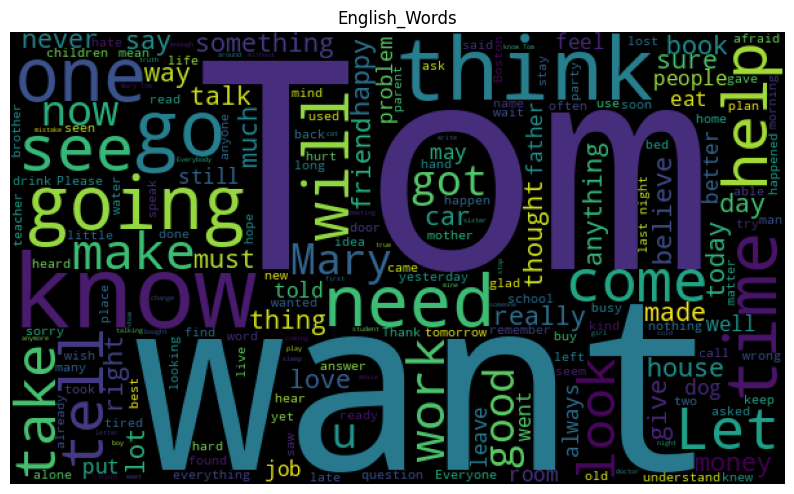

In [ ]:
display_words(english, "English_Words")

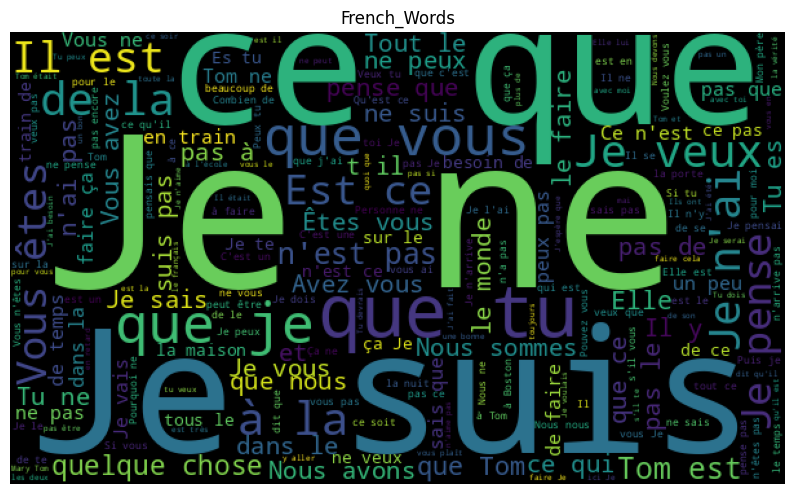

In [ ]:
display_words(french, "French_Words")

# Preprocessing the Data

**Creating a tf.data.Dataset**
it will create batches and shuffle the array of strings efficiently.

In [8]:
lang, target_lang = english, french

In [ ]:
print(lang[223])

We lost.


In [ ]:
print(target_lang[223])

Nous avons été battus.


In [9]:
BUFFER_SIZE = len(lang)
BATCH_SIZE = 64

train_size = np.random.uniform(size=(len(target_lang),)) < 0.8

train = (
    tf.data.Dataset
    .from_tensor_slices((lang[train_size], target_lang[train_size]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val = (
    tf.data.Dataset
    .from_tensor_slices((lang[~train_size], target_lang[~train_size]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [10]:
for lang_example, target_exm in train.take(1):
  print(lang_example[:5])
  print( )
  print(target_exm[:5])

tf.Tensor(
[b'I have to repair the refrigerator.' b"Didn't you know that?"
 b'There are people here who need your help.'
 b'I want to talk to you about tomorrow.' b'We should have a drink.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Il faut que je r\xc3\xa9pare le r\xc3\xa9frig\xc3\xa9rateur.'
 b'Tu ne le savais pas\xe2\x80\xaf?'
 b'Il y a ici des gens qui ont besoin de votre aide.'
 b'Je veux vous parler \xc3\xa0 propos de demain.'
 b'Nous devrions boire un verre.'], shape=(5,), dtype=string)


**text preprocessing**

In [11]:
# unicode normalization

#tf text package contains unicode normalization operation that
# can split the accented character and replace them with comptative character with their ASCII equivalent

# standardization of text

def text_preprocessing(text):
  #unicode normalization
  norm_text = tf_text.normalize_utf8(text, 'NFKD')
  #lowering the characters
  lower_text = tf.strings.lower(text)
  #replacing the special character and extra spaces
  clean_text = tf.strings.regex_replace(lower_text, "[^ a-z?!.,']", '')
  #clean_text = tf.strings.regex_replace(clean_text, '[.?!,]', r' \0 ')
  clean_text = tf.strings.strip(clean_text)

  # adding the start and end to the text.

  clean_text = tf.strings.join(['[START]', clean_text, '[END]'], separator=' ')
  return clean_text

In [ ]:
example_text = tf.constant("Une bonne théorie se caractérise par le fait de faire une série de prédictions qui, en principe, pourraient être réfutées ou mises en défaut par l'observation.")

In [ ]:
print(example_text.numpy().decode())
print()
print(text_preprocessing(example_text).numpy().decode())

Une bonne théorie se caractérise par le fait de faire une série de prédictions qui, en principe, pourraient être réfutées ou mises en défaut par l'observation.

[START] une bonne thorie se caractrise par le fait de faire une srie de prdictions qui, en principe, pourraient tre rfutes ou mises en dfaut par l'observation. [END]


**Text Vectorization**

textvectorization layer of tensorflow will handle the vacabulary extraction and conversion of the text to tokens.

adapt method of this layer read one epoch of training data, works like model.fit , it also detrmines the vocabulary.

In [12]:
max_voc_size = 6000

lang_processor = tf.keras.layers.TextVectorization(standardize = text_preprocessing,
                                                   max_tokens = max_voc_size,
                                                   ragged = True # it returns a ragged tensor
                                                    #(Ragged tensors are the TensorFlow equivalent of nested variable-length lists.
                                                    #They make it easy to store and process data with non-uniform shapes, including:
                                                    #Variable-length features, such as the set of actors in a movie.
                                                    #Batches of variable-length sequential inputs, such as sentences or video clips.)
                                                   )


In [13]:
# english text vectorization layer

lang_processor.adapt(train.map(lambda english, french: english))

# Here are the first 10 words from the vocabulary:
lang_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'i', 'you', 'to', 'the', 'a', 'is']

In [14]:
lang_processor.vocabulary_size()

6000

In [15]:
target_processor = tf.keras.layers.TextVectorization(standardize = text_preprocessing,
                                                   max_tokens = max_voc_size,
                                                   ragged = True # it returns a ragged tensor

                                                   )

In [16]:
# french text vectorization layer

target_processor.adapt(train.map(lambda english, french: french))

# 10 words from vocabulary
target_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'je', 'de', 'pas', 'que', 'ne', 'le']

In [17]:
target_processor.vocabulary_size()

6000

In [18]:
# now these layers can be used to convert the string to token

example_tokens = lang_processor(lang_example)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 4, 17, 6, 2576, 7, 3588, 3], [2, 53, 5, 34, 166, 3],
 [2, 71, 24, 147, 128, 82, 72, 25, 252, 3]]>

In [19]:
# get_vocabulary method convert token back to the text.

english_vocab = np.array(lang_processor.get_vocabulary())
tokens = english_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] i have to repair the refrigerator. [END]'

Text(0.5, 1.0, 'Mask')

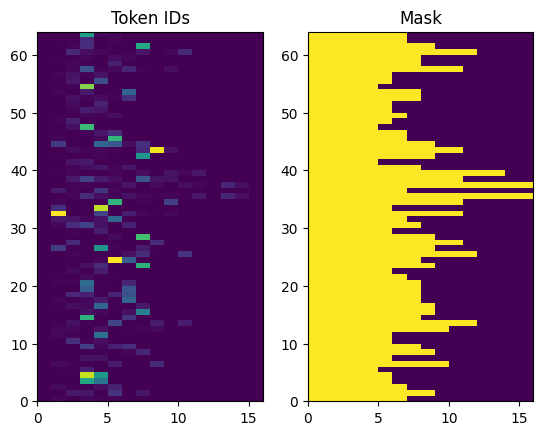

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

**Generating the data**

In [20]:
def Generate_data(lang_1st, lang_2nd):
  input_1 = lang_processor(lang_1st).to_tensor()
  lang_2nd = target_processor(lang_2nd)

  input_2 = lang_2nd[:, :-1].to_tensor()

  output = lang_2nd[:, 1:].to_tensor()

  return((input_1, input_2), output)



In [21]:
# creating the dataset for the training and validation.

# training set
train_data = train.map(Generate_data, tf.data.AUTOTUNE)

#validation set
val_data = val.map(Generate_data, tf.data.AUTOTUNE)

In [22]:
for (input_1, input_2), output in train_data.take(1):
  print(f"input 1:{(input_1[0, :10].numpy())}")
  print()
  print(f"input 2:{input_2[0, :10].numpy()}")
  print(f"output: {output[0, :10].numpy()}")

input 1:[   2   17    5  506    7 1148 3142    3    0    0]

input 2:[   2  103  154  582   10 5354   11    0    0    0]
output: [ 103  154  582   10 5354   11    3    0    0    0]


# Creating Model

In [23]:
# defining some parameter

UNITS = 256
EPOCH = 15
BATCH_SIZE = 148
max_len = 64

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape = (max_len))
x = Embedding(lang_processor.vocabulary_size(), UNITS, mask_zero = True)(encoder_inputs)
encoder_outputs = Bidirectional(merge_mode = 'sum',
                                layer = GRU(UNITS,
                                # Return the sequence and state
                                return_sequences = True,
                                recurrent_initializer = 'glorot_uniform'))(x)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape = (max_len))
decoder_embeddings = Embedding(target_processor.vocabulary_size(), UNITS, mask_zero = True)(decoder_inputs)

x = LSTM(UNITS, return_sequences = True, dropout = 0.2)(decoder_embeddings, initial_state = None)

#Attention
attention = MultiHeadAttention(num_heads = 1, key_dim = UNITS, dropout = 0.2)
attention_output, attention_scores = attention(query = x, value = encoder_outputs, return_attention_scores = True)

add = Add()
normalization = LayerNormalization()

attention_seq = add([x, attention_output])
attention_seq = normalization(attention_seq)

decoder_outputs = Dense(target_processor.vocabulary_size())(attention_seq)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
# creating a masked loss and masked accuracy function
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [25]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss = masked_loss,
              metrics = [masked_acc, masked_loss])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 256)              1536000   ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 64, 256)              1536000   ['input_1[0][0]']             
                                                                                              

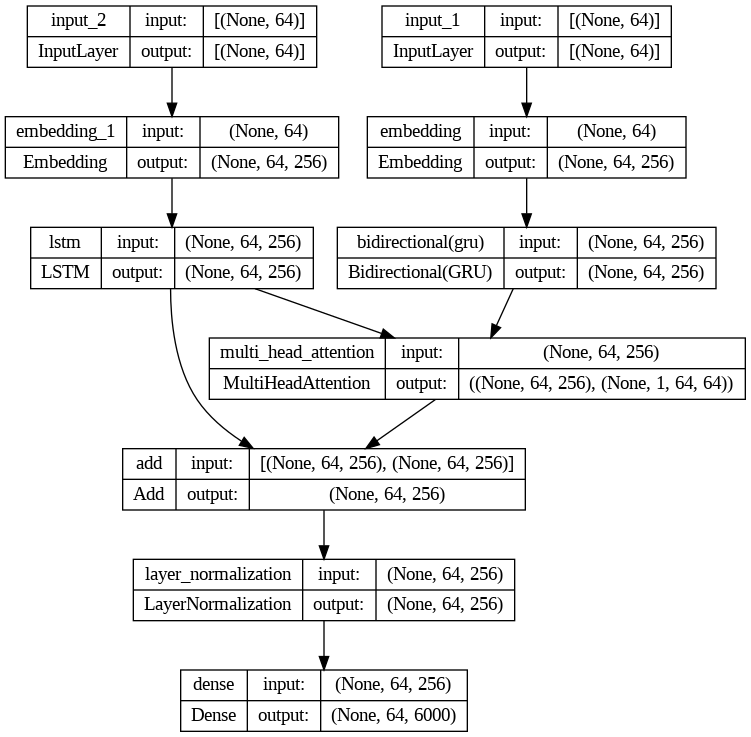

In [ ]:
# plotting the model
plot_model(model, show_shapes=True)

In [ ]:
model.evaluate(val_data, steps=20, return_dict=True)

20/20 [==============================] - 10s 24ms/step - loss: 8.7082 - masked_acc: 0.0000e+00 - masked_loss: 8.7082


{'loss': 8.708220481872559,
 'masked_acc': 0.0,
 'masked_loss': 8.708230018615723}

**Training the model**

In [ ]:
history = model.fit(train_data,
                    epochs = EPOCH,
                    batch_size = BATCH_SIZE,
                    validation_data = val_data,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
                    )

Epoch 1/15
2198/2198 [==============================] - 105s 38ms/step - loss: 2.6029 - masked_acc: 0.5168 - masked_loss: 2.6035 - val_loss: 1.5335 - val_masked_acc: 0.6557 - val_masked_loss: 1.5348
Epoch 2/15
2198/2198 [==============================] - 74s 34ms/step - loss: 1.4532 - masked_acc: 0.6604 - masked_loss: 1.4545 - val_loss: 1.2905 - val_masked_acc: 0.6937 - val_masked_loss: 1.2917
Epoch 3/15
2198/2198 [==============================] - 71s 32ms/step - loss: 1.2076 - masked_acc: 0.6997 - masked_loss: 1.2085 - val_loss: 1.2019 - val_masked_acc: 0.7093 - val_masked_loss: 1.2029
Epoch 4/15
2198/2198 [==============================] - 72s 33ms/step - loss: 1.0631 - masked_acc: 0.7249 - masked_loss: 1.0641 - val_loss: 1.1717 - val_masked_acc: 0.7164 - val_masked_loss: 1.1726
Epoch 5/15
2198/2198 [==============================] - 74s 34ms/step - loss: 0.9580 - masked_acc: 0.7442 - masked_loss: 0.9587 - val_loss: 1.1430 - val_masked_acc: 0.7236 - val_masked_loss: 1.1438
Epoch 6/1

**Plotting the Learning Curves**

In [ ]:
# Converting the keras history object to DataFrame
if not isinstance(history, tf.keras.callbacks.History):
  raise ValueError("'history' must be keras.callbacks.History object.")

history = pd.DataFrame(history.history)

In [ ]:
FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"

fig = px.line(
    history,
    markers=True,
    height=540,
    width=840,
    symbol="variable",
    labels={"variable": "Variable", "value": "Value", "index": "Epoch"},
    title="Language Translation With Attention",
    color_discrete_sequence=px.colors.diverging.balance_r,
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()

In [ ]:
#Saving the model.

#changing the directory
os.chdir('/content/drive/MyDrive')

# saving the model.
model.save('/content/drive/MyDrive'+'/English_2_French_Translation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Loading the model
my_model = load_model('/content/drive/MyDrive/English_2_French_Translation.h5', custom_objects = {'masked_loss': masked_loss , 'masked_acc': masked_acc})

In [27]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 256)              1536000   ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 64, 256)              1536000   ['input_1[0][0]']             
                                                                                              

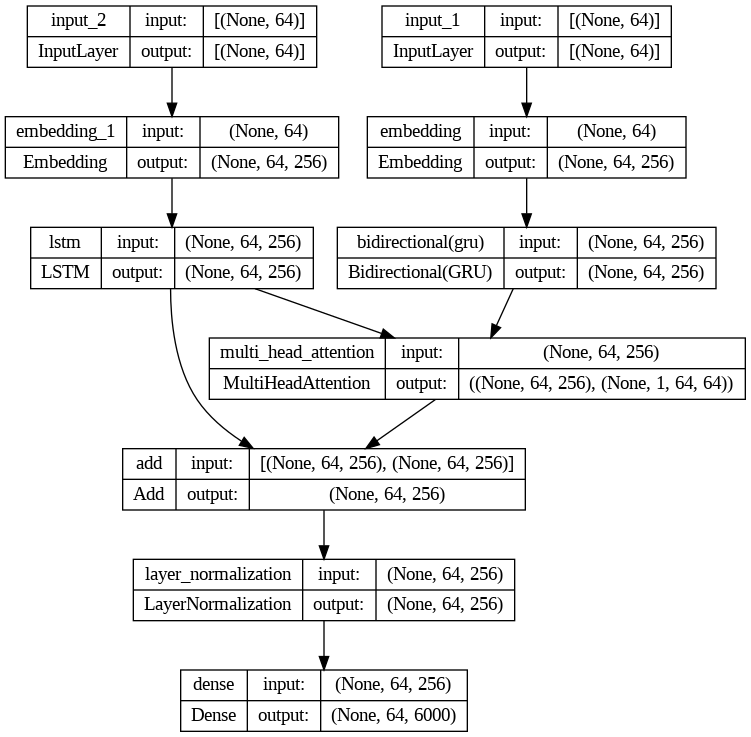

In [28]:
plot_model(my_model, show_shapes = True)

# Translating The New English Word/Sentance.